# Visualizing FIRMS Fire Detection Data

## Visible Infrared Imaging Radiometer Suite or VIIRS is an instrument that collects high-resolution, including visible and infrared images of hurricanes and detection of fires, smoke, and particles in the atmosphere. 

## In downloading a sample dataset, VIIRS SNPP from July 12, 2023, fires can be detected in and around Canada. 

## First - basic earth data is to be obtained. 

<Axes: >

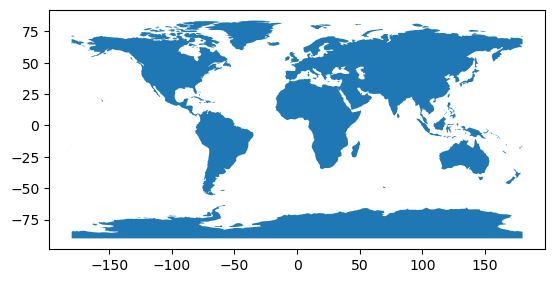

In [2]:
path = get_path("naturalearth.land")
world = geopandas.read_file(path)

# and test our libraries loaded

world.plot()

## Then - a common map projection can be chosen. 

<GeoAxes: title={'center': 'EPSG:3857'}>

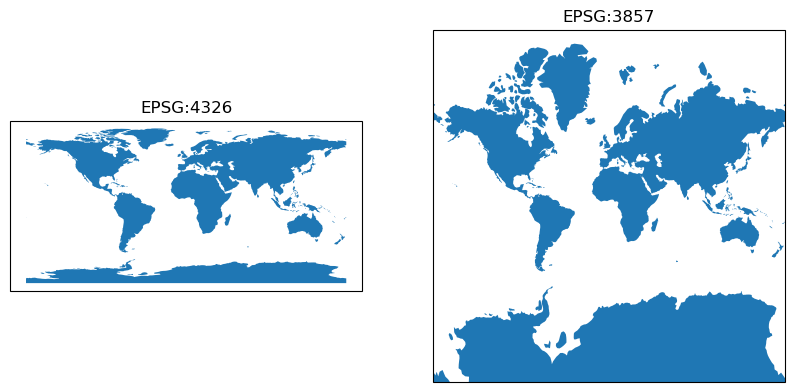

In [3]:
crs = ccrs.epsg("3857")
world_epsg = world.to_crs(epsg="3857")

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": crs}, figsize=(10, 5))
axs[0].set(title='EPSG:4326')
axs[1].set(title='EPSG:3857')
world.plot(ax=axs[0])
world_epsg.plot(ax=axs[1])

## Map projection EPSG:4326 will be map of choice due to its popularity.

## Here are the some of the records from the NASA VIIRS SNPP dataset with longtitude and latitude values of fire detection imagery.

In [5]:
import pandas as pd
df = pd.read_csv('https://firms.modaps.eosdis.nasa.gov/content/notebooks/sample_viirs_snpp_071223.csv')

# show top 5 records
df.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,0.05836,29.59085,295.64,0.38,0.59,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.83,N
1,0.48765,31.50760,296.73,0.51,0.66,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.56,N
2,2.15227,13.94524,305.26,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,287.94,1.08,N
3,2.15681,13.94618,319.05,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,288.77,1.81,N
4,2.15754,13.94131,301.13,0.51,0.50,2023-07-12,3,N,VIIRS,n,2.0NRT,288.17,1.81,N


## Next is a conversion of longitude, latitude values into point geometry.

In [6]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# show top 3 records
gdf.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,geometry
0,0.05836,29.59085,295.64,0.38,0.59,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.83,N,POINT (29.59085 0.05836)
1,0.48765,31.50760,296.73,0.51,0.66,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.56,N,POINT (31.50760 0.48765)
2,2.15227,13.94524,305.26,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,287.94,1.08,N,POINT (13.94524 2.15227)


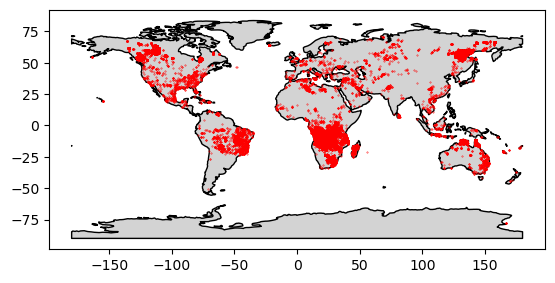

In [7]:
ax = world.plot(color="lightgrey", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", markersize=0.1)

plt.show()

## Now to show fire detections in or around Canada using FIRMS Regional Coordinates. 

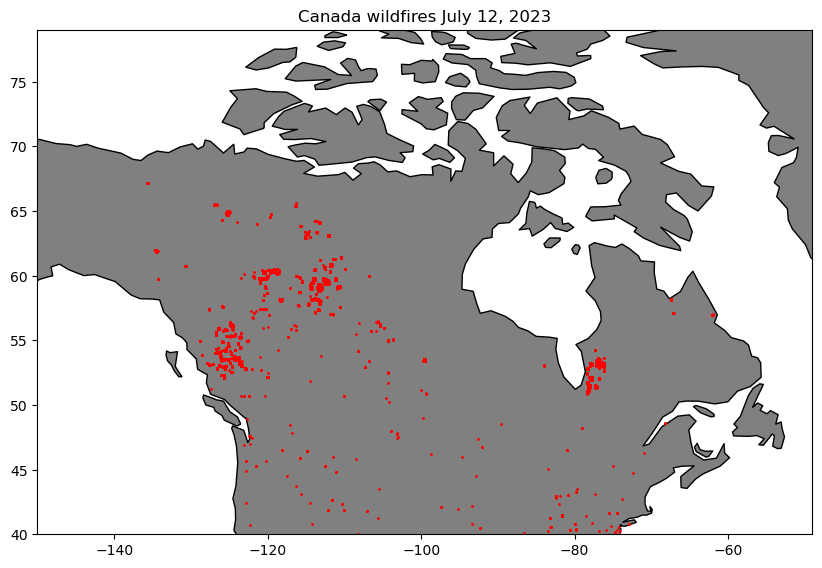

In [8]:
df_canada = df[(df['longitude'] >= -150) & (df['latitude'] >= 40) & (df['longitude'] <= -49) & (df['latitude'] <= 79)].copy()

# create geometry for points using latitude and longitude and specifying projection as EPSG:4326

gdf = geopandas.GeoDataFrame(
    df_canada, geometry=geopandas.points_from_xy(df_canada.longitude, df_canada.latitude), crs="EPSG:4326"
)

# set our extent
extent = [-150, 40, -49, 79]
ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")
ax.set_xlim([extent[0],  extent[2]])
ax.set_ylim([extent[1],  extent[3]])

ax.set(title='Canada wildfires July 12, 2023')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", markersize=1)

plt.show()


## To visualize data based on time it was detected, newer data will different colors.
## With a current data and time of 2023 July 12, 19:50 (7:50pm) GMT, the color coding will be:

### dark red; detections <= 1 hour
### red; detections > 1 hour but less than or equal to 4 hours
### orange; detections > 4hours and less than or equal to 12 hours
### yellow; detections older than 12 hours

In [13]:
# convert aqc_date and aqc_time to acq_datetime as datetime object
df_canada['acq_datetime'] = pd.to_datetime(df_canada['acq_date'] + ' ' + df_canada['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')
gdf = geopandas.GeoDataFrame(
    df_canada, geometry=geopandas.points_from_xy(df_canada.longitude, df_canada.latitude), crs="EPSG:4326"
)
# find maximum time from our dataset since we are pretending current date time is July 12 2023, 19:50(7:50pm) GMT.
# if the data were recent, we would set dt_max = pd.Timestamp.now();
dt_max = gdf['acq_datetime'].max()

# create our subsets for 4 color classes

# less than or equal to 1 hour; gdf1 <= 1hour
gdf1 = gdf[gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=1))]

# greater than 1 hour but less than or equal to 4 hours; gdf2 > 1 hour and gdf2 <= 4 hours
gdf2 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=4))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=1)))]

# greater than 4 hours but less than or equal to 12 hours; gdf3 > 4 hours and gdf2 <= 12 hours
gdf3 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=12))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=4)))]

# greater than 12 hours; gdf4 > 12 hours
gdf4 = gdf[gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=12))]

# now let's make sure the sizes are correct. They should all add up to 14045
print ('Sizes %i, %i, %i, %i from total of %i' % (gdf1.count()[0],gdf2.count()[0],gdf3.count()[0],gdf4.count()[0], gdf.count()[0]))

Sizes 3792, 913, 8449, 891 from total of 14045


## We will set the map to view fire detection images in Canada with current data/time set to 2023 July 12, 1950 (7:50pm) GMT with color coding as follows:
### dark red; detections <= 1 hour
### red; detections > 1 hour but less than or equal to 4 hours
### orange; detections > 4hours and less than or equal to 12 hours
### yellow; detections older than 12 hours

In [14]:
# convert aqc_date and aqc_time to acq_datetime as datetime object
df_canada['acq_datetime'] = pd.to_datetime(df_canada['acq_date'] + ' ' + df_canada['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')
gdf = geopandas.GeoDataFrame(
    df_canada, geometry=geopandas.points_from_xy(df_canada.longitude, df_canada.latitude), crs="EPSG:4326"
)
# find maximum time from our dataset since we are pretending current date time is July 12 2023, 19:50(7:50pm) GMT.
# if the data were recent, we would set dt_max = pd.Timestamp.now();
dt_max = gdf['acq_datetime'].max()

# create our subsets for 4 color classes

# less than or equal to 1 hour; gdf1 <= 1hour
gdf1 = gdf[gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=1))]

# greater than 1 hour but less than or equal to 4 hours; gdf2 > 1 hour and gdf2 <= 4 hours
gdf2 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=4))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=1)))]

# greater than 4 hours but less than or equal to 12 hours; gdf3 > 4 hours and gdf2 <= 12 hours
gdf3 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=12))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=4)))]

# greater than 12 hours; gdf4 > 12 hours
gdf4 = gdf[gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=12))]

# now let's make sure the sizes are correct. They should all add up to 14045
print ('Sizes %i, %i, %i, %i from total of %i' % (gdf1.count()[0],gdf2.count()[0],gdf3.count()[0],gdf4.count()[0], gdf.count()[0]))

Sizes 3792, 913, 8449, 891 from total of 14045


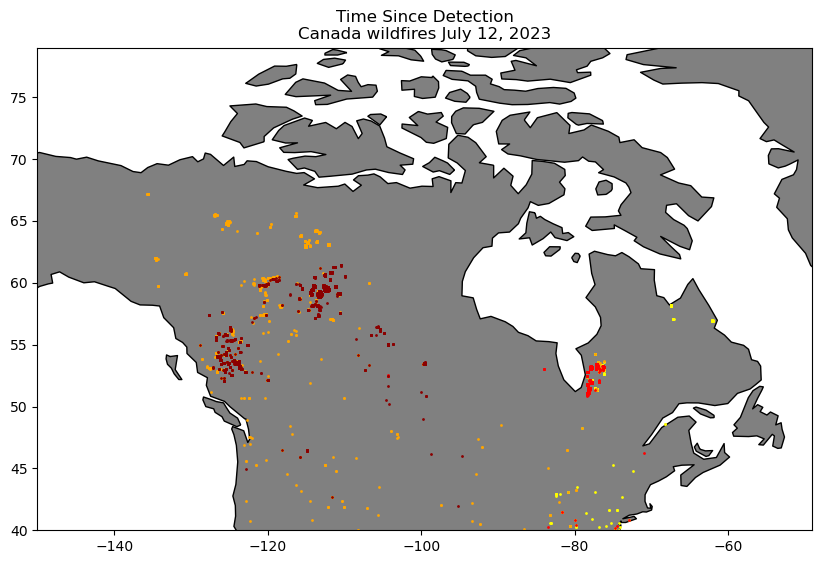

In [16]:
# set our extent to Canada
extent = [-150, 40, -49, 79]
ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")

# set map extent
ax.set_xlim([extent[0],  extent[2]])
ax.set_ylim([extent[1],  extent[3]])

# add graph title
ax.set(title='Time Since Detection\nCanada wildfires July 12, 2023')

# Color code each set; also we are drawing in opposite order, so the older detections are drawn first so the newer ones are on the top
gdf4.plot(ax=ax, color="yellow", markersize=1)
gdf3.plot(ax=ax, color="orange", markersize=1)
gdf2.plot(ax=ax, color="red", markersize=1)
gdf1.plot(ax=ax, color="darkred", markersize=1)

plt.show()

# For our final map, more map detail can enhance the imagery of where fires are detected.

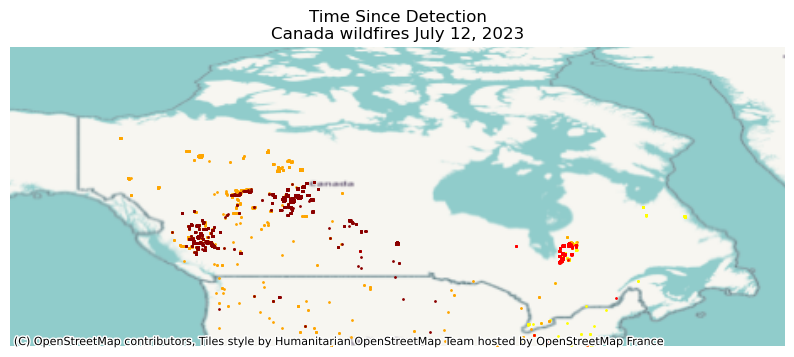

In [17]:
extent = [-150, 40, -49, 79]
ax = world.plot(figsize=(10, 10), alpha=0)

# set our map extent
ax.set_xlim([extent[0],  extent[2]])
ax.set_ylim([extent[1],  extent[3]])

# set title
ax.set(title='Time Since Detection\nCanada wildfires July 12, 2023')
# turn off axis labels
ax.set_axis_off()

# Color code each set; also we are drawing in opposite order, so the older detections are drawn first so the newer ones are on the top
if gdf4.count()[0] > 0 :
  gdf4.plot(ax=ax, color="yellow", markersize=1)
if gdf3.count()[0] > 0 :
  gdf3.plot(ax=ax, color="orange", markersize=1)
if gdf2.count()[0] > 0 :
  gdf2.plot(ax=ax, color="red", markersize=1)
if gdf1.count()[0] > 0 :
  gdf1.plot(ax=ax, color="darkred", markersize=1)

# add basemap
cx.add_basemap(ax, crs=gdf1.crs)

# show our map plot
plt.show()

#### Page References

#### NOAA National Environmental Satellite, Data, and Information Science. Visible Infrared Imaging Radiometer Suite (VIIRS). Retrieved from https://www.nesdis.noaa.gov/our-satellites/currently-flying/joint-polar-satellite-system/visible-infrared-imaging-radiometer-suite-viirs#:~:text=VIIRS%20features%20daily%20imaging%20capabilities,the%20atmosphere%2C%20such%20as%20dust.

#### NASA Firms - Visualization in Python. Retrieved from https://firms.modaps.eosdis.nasa.gov/content/academy/data_visualization/firms_visualization.html. 